In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score, classification_report,
    roc_curve, precision_recall_curve, auc
)

url = "https://raw.githubusercontent.com/akay6483/mmml-ecommerce/main/dataset/data_ecommerce_customer_churn.csv"
df = pd.read_csv(url)

X = df.drop('Churn', axis=1)
y = df['Churn']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_comparison = []

def evaluate_and_visualize(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    print(f"--- {model_name} Evaluation ---")
    print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f} | F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f} | PR AUC: {pr_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    model_comparison.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1_Score": f1,
        "ROC_AUC": roc_auc,
        "PR_AUC": pr_auc
    })

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'{model_name} - Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    axes[1].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange', lw=2)
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'{model_name} - ROC Curve')
    axes[1].legend(loc="lower right")

    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
    axes[2].plot(recall_curve, precision_curve, label=f'PR AUC = {pr_auc:.2f}', color='green', lw=2)
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title(f'{model_name} - Precision-Recall Curve')
    axes[2].legend(loc="lower left")

    plt.tight_layout()
    plt.show()

print("Setup Complete. Ready to train models.")

Setup Complete. Ready to train models.


--- K-Nearest Neighbour Evaluation ---
Accuracy: 0.8859 | Precision: 0.7600 | Recall (Sensitivity): 0.4419
Specificity: 0.9727 | F1 Score: 0.5588
ROC AUC: 0.9123 | PR AUC: 0.6237

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       660
           1       0.76      0.44      0.56       129

    accuracy                           0.89       789
   macro avg       0.83      0.71      0.75       789
weighted avg       0.88      0.89      0.87       789



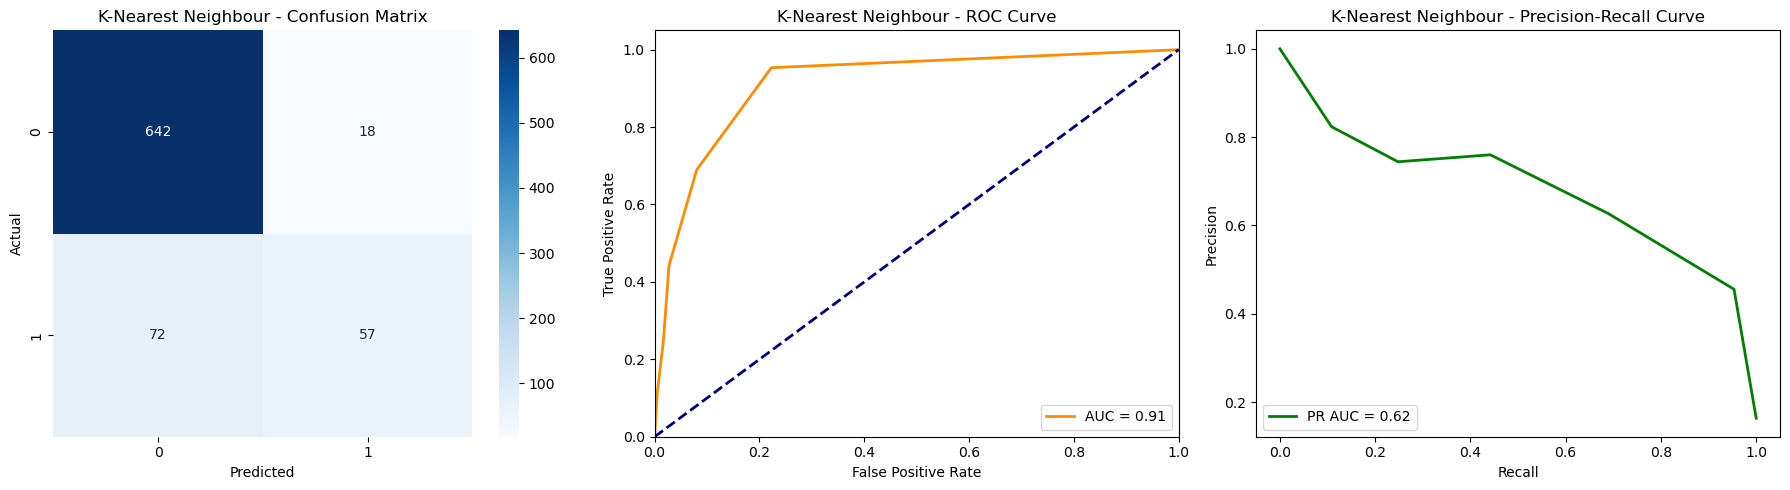

In [3]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', KNeighborsClassifier(n_neighbors=5))])

knn_model.fit(X_train, y_train)

evaluate_and_visualize(knn_model, "K-Nearest Neighbour", X_test, y_test)

--- Logistic Regression Evaluation ---
Accuracy: 0.8935 | Precision: 0.7711 | Recall (Sensitivity): 0.4961
Specificity: 0.9712 | F1 Score: 0.6038
ROC AUC: 0.8868 | PR AUC: 0.6797

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       660
           1       0.77      0.50      0.60       129

    accuracy                           0.89       789
   macro avg       0.84      0.73      0.77       789
weighted avg       0.89      0.89      0.88       789



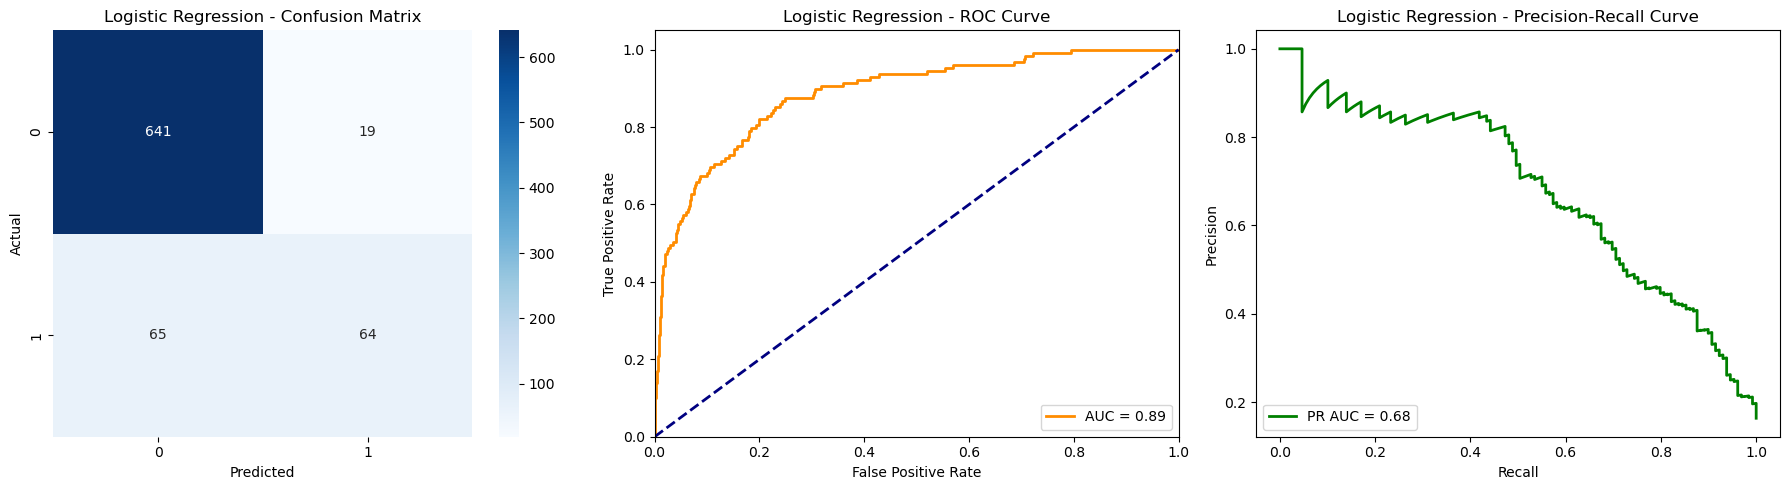

In [4]:
from sklearn.linear_model import LogisticRegression

lr_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=1000, random_state=42))])

lr_model.fit(X_train, y_train)

evaluate_and_visualize(lr_model, "Logistic Regression", X_test, y_test)

--- Naive Bayes Evaluation ---
Accuracy: 0.7427 | Precision: 0.3555 | Recall (Sensitivity): 0.7054
Specificity: 0.7500 | F1 Score: 0.4727
ROC AUC: 0.8066 | PR AUC: 0.5018

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       660
           1       0.36      0.71      0.47       129

    accuracy                           0.74       789
   macro avg       0.64      0.73      0.65       789
weighted avg       0.83      0.74      0.77       789



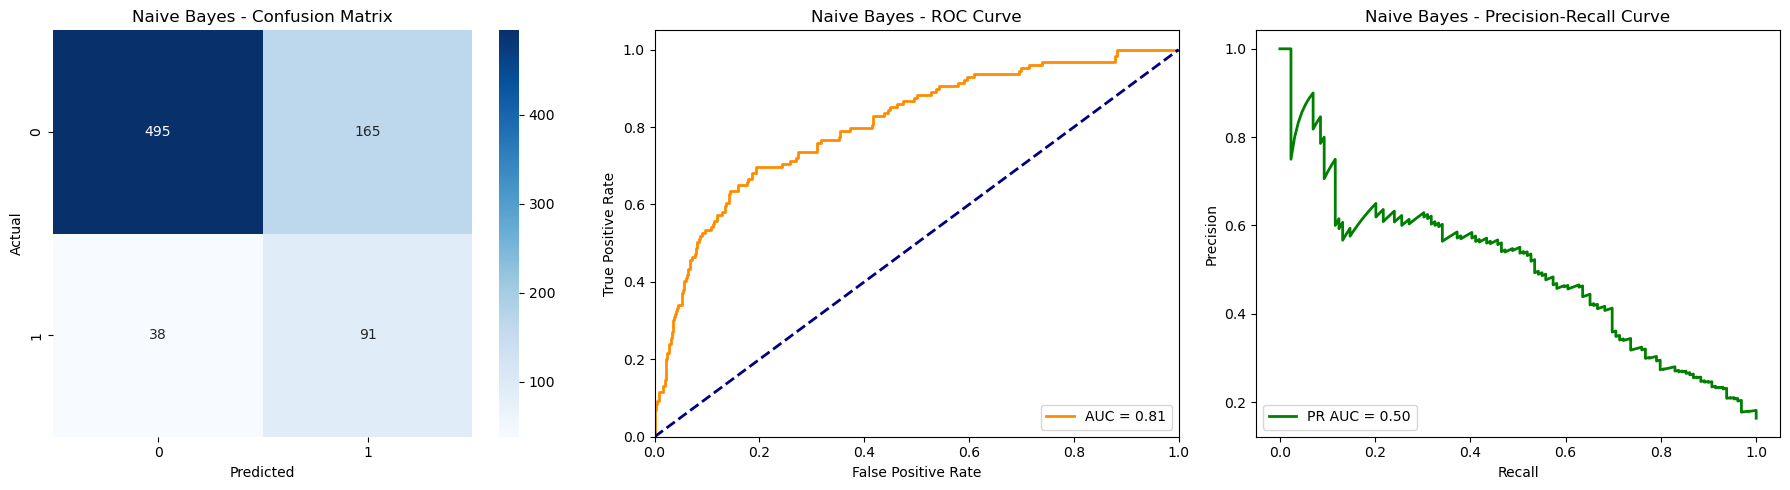

In [5]:
from sklearn.naive_bayes import GaussianNB

nb_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', GaussianNB())])

nb_model.fit(X_train, y_train)

evaluate_and_visualize(nb_model, "Naive Bayes", X_test, y_test)

Final Cross-Model Comparison:


,Model,Accuracy,Precision,Recall,Specificity,F1_Score,ROC_AUC,PR_AUC
1,Logistic Regression,0.893536,0.771084,0.496124,0.971212,0.603774,0.886833,0.679704
0,K-Nearest Neighbour,0.885932,0.760000,0.441860,0.972727,0.558824,0.912303,0.623651
2,Naive Bayes,0.742712,0.355469,0.705426,0.750000,0.472727,0.806577,0.501778


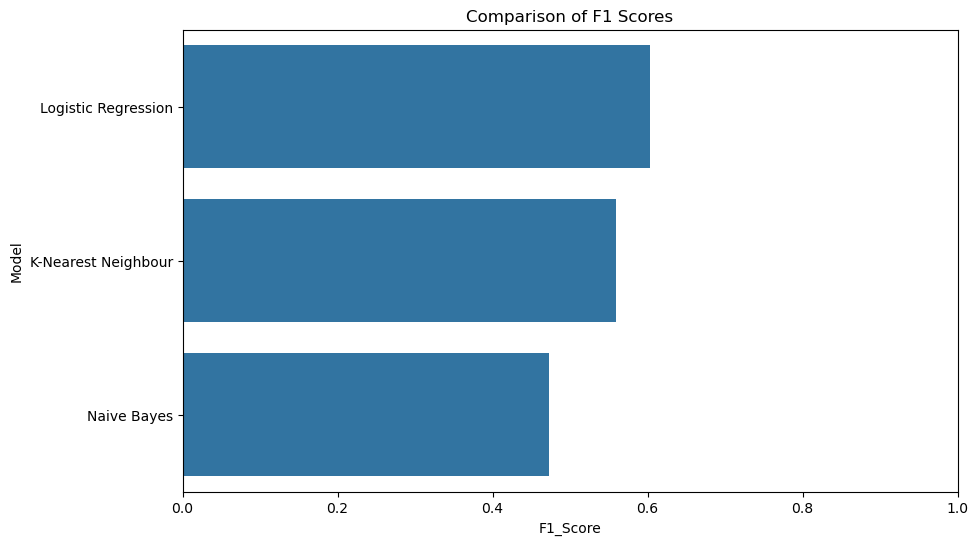

In [6]:
results_df = pd.DataFrame(model_comparison)

results_df = results_df.sort_values(by='F1_Score', ascending=False)

print("Final Cross-Model Comparison:")
try:
    display(results_df.style.background_gradient(cmap='Greens'))
except:
    print(results_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='F1_Score', y='Model', data=results_df)
plt.title('Comparison of F1 Scores')
plt.xlim(0, 1)
plt.show()